In [1]:
import matplotlib.pyplot as plt
import pandapower.plotting
from pandapower.tdpf.test_system import *
from pandapower.tdpf.create_jacobian_tdpf import *

In [2]:
net = test_grid(load_scaling=0.25, sgen_scaling=0.5, with_gen=True, distributed_slack=False)

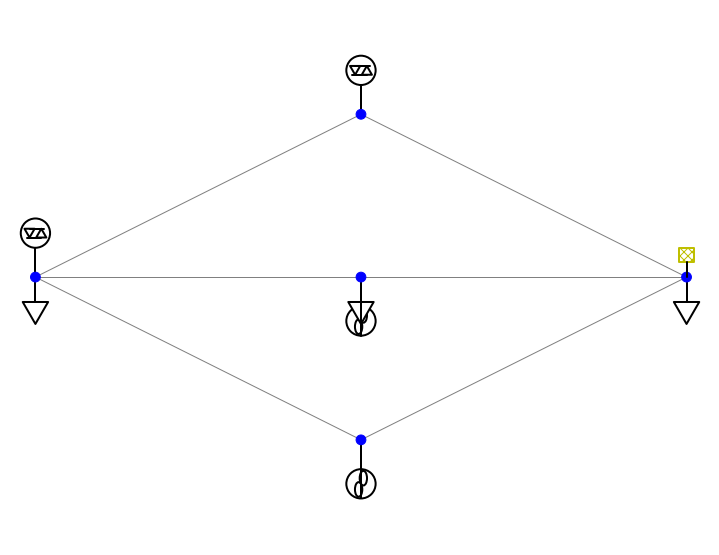

<AxesSubplot:>

In [3]:
pp.plotting.simple_plot(net, plot_loads=True, plot_sgens=True, plot_gens=True, load_size=3, sgen_size=3, gen_size=3)

In [4]:
pp.runpp(net, init="flat", lightsim2grid=False)
net.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
0,2.520700,56.677782,-2.264601,-55.071738,0.256099,1.606044,0.241507,0.241507,0.241507,1.027490,2.981261,0.998232,3.173039,25.156976
1,97.479300,-56.677782,-96.467660,63.021966,1.011640,6.344184,0.479997,0.479997,0.479997,1.027490,2.981261,1.050000,0.000000,49.999724
2,-88.710098,11.671945,89.248383,-8.296260,0.538285,3.375684,0.392043,0.392043,0.392043,0.998232,3.173039,1.000000,5.357838,40.837850
3,65.974699,-16.600207,-65.779624,17.823557,0.195075,1.223350,0.298086,0.298086,0.298086,0.998232,3.173039,1.000000,2.135568,31.050611
4,210.751617,-141.687706,-206.430677,168.785130,4.320941,27.097424,1.110752,1.110752,1.110752,1.000000,5.357838,1.050000,0.000000,115.703355
5,-113.442497,220.182604,115.779624,-205.526046,2.337127,14.656558,1.031768,1.031768,1.031768,1.050000,0.000000,1.000000,2.135568,107.475804


In [5]:
net._ppc["internal"].keys()

dict_keys(['Ybus', 'Yf', 'Yt', 'branch_is', 'gen_is', 'DLF', 'buses_ord_bfs_nets', 'ref_gens', 'J', 'Vm_it', 'Va_it', 'bus', 'gen', 'branch', 'baseMVA', 'V', 'pv', 'pq', 'ref', 'Sbus', 'T'])

In [6]:
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.027490,2.981261,-100.000000,-0.000000
1,0.998232,3.173039,25.000000,60.000000
2,1.000000,5.357838,-300.000000,149.983966
3,1.050000,0.000000,416.340834,-451.989700
4,1.000000,2.135568,-50.000000,187.702489


In [7]:
t_amb_pu = 35
alpha_pu = 4e-3
r_ref = net.line.r_ohm_per_km.values / 1e3
a0, a1, a2, tau = calc_a0_a1_a2_tau(t_amb_pu, 80, 20, r_ref, 30.6e-3,
                                    1490, 0.6, 45, 900, alpha_pu, 0.5, 0.5)
T=calc_T_ngoko(np.square(net.res_line.i_ka.values * 1e3), a0, a1, a2, None, None, None)
T

array([46.05926996, 53.12154882, 49.93833344, 47.29144877, 99.9890416 ,
       91.40392366])

In [8]:
branch = net._ppc["branch"]
tdpf_lines = np.ones(len(branch)).astype(bool)
r = branch[tdpf_lines, BR_R].real
#r = r * (1 + alpha_pu * (T - 20))
x = branch[tdpf_lines, BR_X].real
g, b = calc_g_b(r, x)
Vm = abs(net._ppc["internal"]["V"])
Va = np.angle(net._ppc["internal"]["V"])
i_square_pu, p_loss_pu = calc_i_square_p_loss(branch, tdpf_lines, g, b, Vm, Va)
#i_square_pu = np.square(net.res_line.i_ka.values*1e3)
r_theta = calc_r_theta(t_amb_pu, a0, a1, a2, np.square(net.res_line.i_ka.values*1e3), p_loss_pu)
calc_T_frank(p_loss_pu, t_amb_pu, r_theta, None, None, None)

array([46.05926996, 53.12154882, 49.93833344, 47.29144877, 99.9890416 ,
       91.40392366])

In [9]:
p_loss_pu

array([0.00256099, 0.0101164 , 0.00538285, 0.00195075, 0.04320941,
       0.02337127])

In [10]:
i_base_a = net.sn_mva / (132 * np.sqrt(3)) * 1e3
1e-3 * i_base_a * np.sqrt(i_square_pu)

array([0.24150697, 0.47999735, 0.39204336, 0.29808586, 1.11075221,
       1.03176772])

In [11]:
np.sqrt(i_square_pu)

array([0.5521591 , 1.09742133, 0.89633151, 0.68151582, 2.53952063,
       2.35893783])

In [12]:
net.res_line[['i_ka', 'pl_mw']]

,i_ka,pl_mw
0,0.241507,0.256099
1,0.479997,1.011640
2,0.392043,0.538285
3,0.298086,0.195075
4,1.110752,4.320941
5,1.031768,2.337127


In [13]:
pp.runpp(net, tdpf=True, max_iteration=30)

In [14]:
net.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent,r_ohm_per_km,temperature_degree_celsius
0,1.145704,57.860539,-0.851651,-56.191113,0.294053,1.669426,0.246226,0.246226,0.246226,1.028013,3.058060,0.998271,3.324106,25.648576,0.065172,46.151857
1,98.854296,-57.860539,-97.672056,64.400365,1.182241,6.539826,0.487342,0.487342,0.487342,1.028013,3.058060,1.050000,0.000000,50.764815,0.066887,53.419294
2,-89.838066,13.737926,90.460324,-10.255459,0.622257,3.482468,0.398196,0.398196,0.398196,0.998271,3.324106,1.000000,5.550365,41.478734,0.066113,50.138432
3,65.689717,-17.546813,-65.473610,18.768694,0.216107,1.221881,0.297907,0.297907,0.297907,0.998271,3.324106,1.000000,2.284085,31.031951,0.065440,47.287124
4,209.539677,-151.708806,-203.578074,179.827572,5.961603,28.118767,1.131492,1.131492,1.131492,1.000000,5.550365,1.050000,0.000000,117.863704,0.078446,102.396571
5,-112.343080,225.658937,115.473610,-210.478384,3.130530,15.180553,1.050049,1.050049,1.050049,1.050000,0.000000,1.000000,2.284085,109.380148,0.076301,93.310661


In [15]:
calc_T_ngoko(np.square(net.res_line.i_ka.values * 1e3), a0, a1, a2, None, None, None)

array([ 46.15185728,  53.41929414,  50.13843149,  47.28712425,
       102.39657035,  93.31066069])

In [16]:
pp.runpp(net)
calc_T_ngoko(np.square(net.res_line.i_ka.values * 1e3), a0, a1, a2, None, None, None)

array([46.05926996, 53.12154882, 49.93833344, 47.29144877, 99.9890416 ,
       91.40392366])

In [17]:
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.027490,2.981261,-100.000000,-0.000000
1,0.998232,3.173039,25.000000,60.000000
2,1.000000,5.357838,-300.000000,149.983966
3,1.050000,0.000000,416.340834,-451.989700
4,1.000000,2.135568,-50.000000,187.702489


In [18]:
net = test_grid(load_scaling=0.25, sgen_scaling=0.5, with_gen=True, distributed_slack=True)
net.sn_mva=1000; pp.runpp(net, tdpf=True, max_iteration=30, tolerance_mva=1e-6)

In [19]:
calc_T_ngoko(np.square(net.res_line.i_ka.values * 1e3), a0, a1, a2, None, None, None)

array([46.09158876, 51.83971441, 46.60045403, 45.52498148, 81.1766181 ,
       88.07531272])

In [20]:
pp.runpp(net)
calc_T_ngoko(np.square(net.res_line.i_ka.values * 1e3), a0, a1, a2, None, None, None)

array([46.04039821, 51.62883854, 46.52450032, 45.54916817, 79.69042504,
       86.69404878])

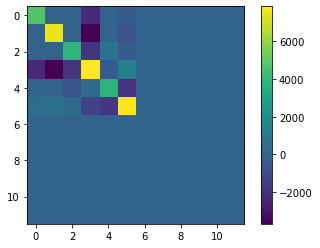

In [21]:
net = test_grid(load_scaling=0.25, sgen_scaling=0.5, with_gen=True, distributed_slack=False)
net.sn_mva = 1
pp.runpp(net, tdpf=True, max_iteration=30)
ax=plt.imshow(net._ppc["internal"]["J"].toarray())
plt.colorbar(ax)

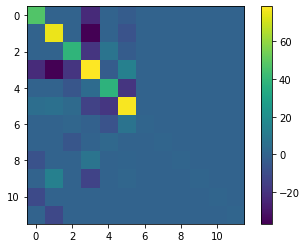

In [22]:
net.sn_mva = 100; pp.runpp(net, tdpf=True, max_iteration=30)
ax=plt.imshow(net._ppc["internal"]["J"].toarray())
plt.colorbar(ax)

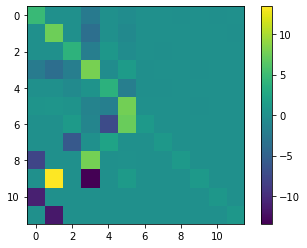

In [23]:
net.sn_mva = 1000; pp.runpp(net, tdpf=True, max_iteration=30)
ax=plt.imshow(net._ppc["internal"]["J"].toarray())
plt.colorbar(ax)

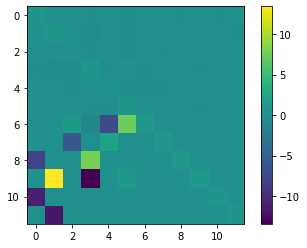

In [24]:
net.sn_mva = 10000; pp.runpp(net, tdpf=True, max_iteration=30)
ax=plt.imshow(net._ppc["internal"]["J"].toarray())
plt.colorbar(ax)

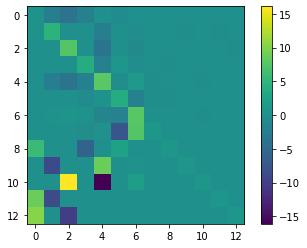

In [25]:
net = test_grid(load_scaling=0.25, sgen_scaling=0.5, with_gen=True, distributed_slack=True)
net.sn_mva=1000; pp.runpp(net, tdpf=True, max_iteration=30, tolerance_mva=1e-6)
ax=plt.imshow(net._ppc["internal"]["J"].toarray())
plt.colorbar(ax)

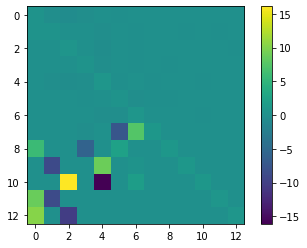

In [26]:
net = test_grid(load_scaling=0.25, sgen_scaling=0.5, with_gen=True, distributed_slack=True)
net.sn_mva=10000; pp.runpp(net, tdpf=True, max_iteration=30)
ax=plt.imshow(net._ppc["internal"]["J"].toarray())
plt.colorbar(ax)

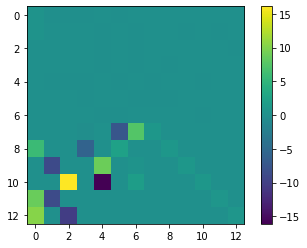

In [27]:
net = test_grid(load_scaling=0.25, sgen_scaling=0.5, with_gen=True, distributed_slack=True)
net.sn_mva=100000000; pp.runpp(net, tdpf=True, max_iteration=30)
ax=plt.imshow(net._ppc["internal"]["J"].toarray())
plt.colorbar(ax)